In [ ]:
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
#from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV

In [2]:
target='Disbursed'
IDcol = 'ID'

In [3]:
train=pd.read_csv('train_modified1.csv')

In [4]:
#train = pd.read_csv('train_modified.csv')


predictors = [x for x in train.columns if x not in [target, IDcol]]


In [35]:
train.shape

(87020, 51)

In [6]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=None)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight'))
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return alg


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.895159


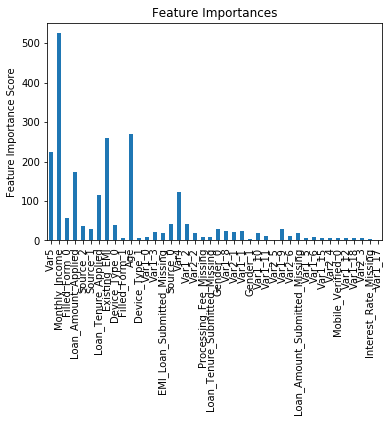

In [7]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

alg=modelfit(xgb1, train, predictors)

In [40]:
train_predictions = alg.predict(train[predictors])


(array([8.7018e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

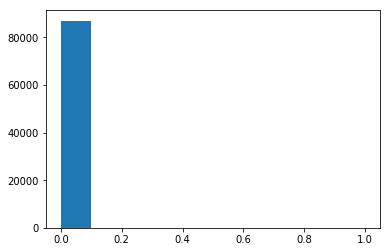

In [41]:
import matplotlib.pyplot as plt
plt.hist(alg.predict(train[predictors]))

In [28]:
test = pd.read_csv('test_modified.csv')

test_predictors = [x for x in train.columns if x not in [target, IDcol]]

In [29]:
test.head()

,Existing_EMI,ID,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,Interest_Rate_Missing,...,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2
0,0.0,ID000026A10,100000,3,21500,3,3,28,0,0,...,0,0,0,0,0,0,1,1,0,0
1,0.0,ID000054C40,0,0,42000,5,8,35,0,0,...,1,0,0,0,0,0,1,0,1,0
2,0.0,ID000066O10,300000,2,10000,1,0,26,1,1,...,0,0,0,0,0,1,0,0,1,0
3,0.0,ID000110G00,0,0,14650,1,0,24,1,1,...,1,0,0,0,0,1,0,0,1,0
4,5000.0,ID000113J30,100000,1,23400,1,0,28,1,1,...,0,0,0,0,0,0,1,0,0,1


In [30]:
test.shape

(37717, 50)

In [31]:
def modelpred(alg, dtest, predictors):
        
    #Predict training set:
    dtest_predictions = alg.predict(dtest[predictors])
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
    return dtest_predictions,dtest_predprob

In [32]:
val1,val2=modelpred(alg, test, test_predictors)

In [33]:
val1

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

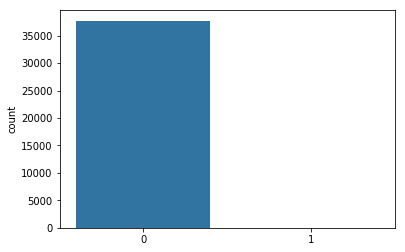

In [34]:
import seaborn as sns
sns.countplot(val1)

In [39]:
#sub_df = pd.DataFrame({"ID_code":test["ID"].values})
#sub_df["target"] = val1
sub_df.to_csv("submission_XGB.csv", index=False)

In [38]:
sub_df.head()

,ID_code,target
0,ID000026A10,0
1,ID000054C40,0
2,ID000066O10,0
3,ID000110G00,0
4,ID000113J30,0
